# K-Means Clustering with Python

## Objectives
After this workshop, you will be able to:
* describe the k-means clustering algorithm
* understand the limits of k-means clustering
* edit and execute cells in a Jupyter notebook
* use a pandas DataFrame object
* find which Olympic event you're best suited for!

## Chapter 0: What does *k-means* mean?

K-means is a clustering algorithm to divide groups of data into *k* number of clusters. It is unsupervised learning, so the clustering happens on unlabeled, unclassified data without any guidance.

The steps are:
1. Initialize *k* cluster centers ("centroids") within the parameters of the data
2. Assign each datapoint to its closest centroid, usually by [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).
3. Update the location of each cluster's centroid.
4. Repeat steps 2 & 3 until the clusters don't change.

![K-Means Clustering](static/kmeans.gif)


### When should I use k-means?

K-means clustering works well on data sets with points that are distinct or well-separated from each other in a linear fashion. For picking the number of centroids, it is useful to pick a *k* value that is well-defined in the data already.

Datasets that have a lot of overlap, outliers, and noise do not lend themselves well to k-means clustering.

<!-- Also talk about local minima -->

### 120 years of Olympic history!
For this workshop, we'll be working with Olympic athlete statistics because:
1. We can easily separate two dimensions (height and weight). There's no need for "dimensionality reduction" (combining multiple features into N dimensions).
2. Based on those two features, the data separates easily into distinct groups.
3. The Olympics are really exciting!

## Chapter 1: Let's import our tools!
Here are some of the libraries we'll be working with:
* `pandas` to store and manipulate the DataFrame objects
* `scikit-learn.cluster.KMeans` method
* `matplotlib.pyplot` for creating a plot
* `seaborn` for making the plot look less ugly

Import those below:

In [18]:
# Imports go here
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as seaborn
from sklearn.cluster import KMeans

## Chapter 2: What is this DataFrame thing?

In [19]:
# Create a pandas DataFrame object from a CSV of Olympian data
olympian_data = pd.read_csv(
    'data/athlete_events.csv',
    usecols=[
        'Name',
        'Sex',
        'Height',
        'Weight',
        'Sport',
        'Team',
    ],
)

Above, we have imported our Olympian data in our CSV file into a data structure called a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). Pandas is a popular library for data science. You can think of a DataFrame as a spreadsheet: it organizes the data into rows and columns for sorting, slicing, and filtering.

Try running the `head()` method on our dataframe below:

In [20]:
# By default, will return the first 5 rows
olympian_data.head()

,Name,Sex,Height,Weight,Team,Sport
0,A Dijiang,M,180.0,80.0,China,Basketball
1,A Lamusi,M,170.0,60.0,China,Judo
2,Gunnar Nielsen Aaby,M,NaN,NaN,Denmark,Football
3,Edgar Lindenau Aabye,M,NaN,NaN,Denmark/Sweden,Tug-Of-War
4,Christine Jacoba Aaftink,F,185.0,82.0,Netherlands,Speed Skating


We can also use `describe()` to see some statistics about our DataFrame values:

In [21]:
# How about describing our data?
olympian_data.describe()

,Height,Weight
count,210945.000000,208241.000000
mean,175.338970,70.702393
std,10.518462,14.348020
min,127.000000,25.000000
25%,168.000000,60.000000
50%,175.000000,70.000000
75%,183.000000,79.000000
max,226.000000,214.000000


### Chapter 2a: Cleaning up our DataFrame

We need to clean up our data a bit. Let's start by dropping duplicates with the `drop_duplicates()` method. We will want to remove any duplicates we find in the `Name` and `Sport` column because some athletes competed in multiple events and/or sports.

In [22]:
# Pass in a list of columns where you want to remove duplicate values
olympian_data = olympian_data.drop_duplicates(subset=['Name', 'Sport'])

Next, we want to remove any row missing data using the `dropna()` method.

In [23]:
# Remove rows with missing values using the dropna() method
olympian_data.dropna(inplace=True)

### Chapter 2b: Slicing our data

Our data is clean! Now, it's time to start slicing and filtering our data before we cluster it using the k-means algorithm.

We're going to want to cluster by two sports (k=2), so first, let's take a look at all the sports we have in our `Sport` column of the DataFrame.

There are two ways to slice a DataFrame by its column:
* Dot notation: `olympian_data.Sport`
* Bracket notation: `olympian_data['Sport']`

In [24]:
# Try sorting the data and calling `.unique()`
sorted(olympian_data.Sport.unique())

['Alpine Skiing',
 'Archery',
 'Art Competitions',
 'Athletics',
 'Badminton',
 'Baseball',
 'Basketball',
 'Beach Volleyball',
 'Biathlon',
 'Bobsleigh',
 'Boxing',
 'Canoeing',
 'Cross Country Skiing',
 'Curling',
 'Cycling',
 'Diving',
 'Equestrianism',
 'Fencing',
 'Figure Skating',
 'Football',
 'Freestyle Skiing',
 'Golf',
 'Gymnastics',
 'Handball',
 'Hockey',
 'Ice Hockey',
 'Judo',
 'Lacrosse',
 'Luge',
 'Modern Pentathlon',
 'Motorboating',
 'Nordic Combined',
 'Rhythmic Gymnastics',
 'Rowing',
 'Rugby',
 'Rugby Sevens',
 'Sailing',
 'Shooting',
 'Short Track Speed Skating',
 'Skeleton',
 'Ski Jumping',
 'Snowboarding',
 'Softball',
 'Speed Skating',
 'Swimming',
 'Synchronized Swimming',
 'Table Tennis',
 'Taekwondo',
 'Tennis',
 'Trampolining',
 'Triathlon',
 'Tug-Of-War',
 'Volleyball',
 'Water Polo',
 'Weightlifting',
 'Wrestling']

For maximal clustering, let's filter out two sports where the athletes might diverge greatly by height and weight. How about Basketball and Gymnastics? What if we separated by Men's and Women's teams as well?

In [25]:
two_sports = olympian_data[((olympian_data.Sport == 'Basketball') 
                            & (olympian_data.Sex == 'M')) | 
                           ((olympian_data.Sport == 'Gymnastics') 
                            & (olympian_data.Sex == 'F'))]

## Chapter 3: Clustering!

Now that we have data that should filter into two groups (Men's Basketball and Women's Gymnastics), it's time to cluster. We are using scikit-learn's `KMeans` method to create a KMeans model. We need to pass in an `n_clusters` argument to tell it how many centroids to cluster around.

We want to call the `fit()` method passing in the DataFrame columns that we want the clustering algorithm to use, in this case: `Weight` and `Height`.

In [26]:
kmeans_model = KMeans(
    n_clusters=2
).fit(
    two_sports[['Weight', 'Height']]
)

Recall that part of the k-means algorithm involves updating the location of the centroids until none of the data points change cluster. Let's see how many iterations it took to find the final centroids with the `n_iter_` attribute:

In [27]:
kmeans_model.n_iter_

3

We can also look at the coordinates of the two cluster centroids at the end of the algorithm's run with the `cluster_centers_` attribute:

In [28]:
kmeans_model.cluster_centers_

array([[ 91.39779965, 195.34047481],
       [ 47.80868444, 156.30782459]])

It's important to note that the KMeans algorithm just clustered our data based on the two columns of data (`Weight` and `Height`). It has no concept of which `Sport` each athlete competed in.

Let's add a column to our `two_sports` DataFrame that will show which cluster each athlete should be assigned to. This is the output of the `KMeans` class's `predict()` method.

In [29]:
predictions = kmeans_model.predict(two_sports[['Weight', 'Height']])
two_sports = two_sports.assign(Prediction=predictions)

Now that we've added this extra column, we can look at a few of the rows to see where each athlete is predicted to fall. We could do this with `head()` like we did we above, but let's try slicing the DataFrame with `iloc`.

In [30]:
two_sports.iloc[10:30]

,Name,Sex,Height,Weight,Team,Sport,Prediction
705,Ruth Abeles,F,153.0,48.0,Israel,Gymnastics,1
833,Essameldin Abou El-Nein,M,205.0,102.0,Egypt,Basketball,0
1018,Pedro Abreu Pascal,M,200.0,88.0,Cuba,Basketball,0
1029,"Alejandro ""lex"" Abrines Redondo",M,198.0,93.0,Spain,Basketball,0
1082,Ginko Abukawa-Chiba,F,148.0,46.0,Japan,Gymnastics,1
1120,Andreea Roxana Acatrinei,F,150.0,40.0,Romania,Gymnastics,1
1181,Emilio Achacoso,M,178.0,78.0,Philippines,Basketball,0
1186,Kieron Robert Achara,M,208.0,110.0,Great Britain,Basketball,0
1322,Roberto Acua,M,208.0,109.0,Argentina,Basketball,0
1701,Adilson de Freitas Nascimento,M,195.0,88.0,Brazil,Basketball,0


## Chapter 4: Let's plot!
We'll be using `seaborn` and `matplotlib` to plot our data. First, let's graph our actual data, coloring the datapoints by their sport. As you can see, there are two distinct groups: Men's Basketball athletes and Women's Gymnastics athletes.

Text(0.5, 1.0, 'Athletes, grouped by Sport')

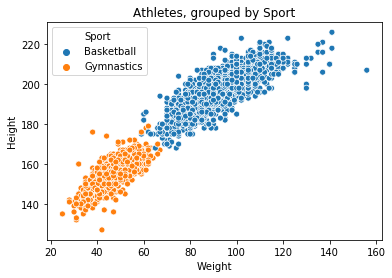

In [31]:
seaborn.scatterplot(
    'Weight',
    'Height',
    data=two_sports[['Weight', 'Height', 'Sport']],
    hue="Sport",
)
# title
plt.title('Athletes, grouped by Sport')

Finally, let's plot our data using the `prediction` column that we added earlier. Instead of coloring the plots by Sport, we will color by which cluster the k-means algorithm predicts they will fall into.

Compare the resulting plot to the one above. How similar are the k-means clusters to the actual sports data?

Text(0.5, 1.0, 'Athletes in predicted clusters')

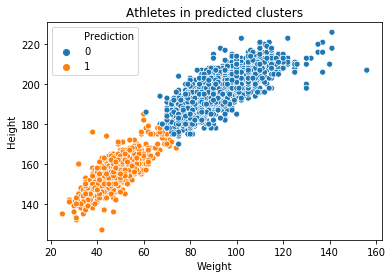

In [32]:
seaborn.scatterplot(
    'Weight',
    'Height',
    data=two_sports[['Weight', 'Height', 'Prediction']],
    hue="Prediction"
)
# title
plt.title('Athletes in predicted clusters')

## Chapter 5: Go to the Olympics!

Every two years, I watch the Olympics and decide that I am destined for athletic glory. Maybe you do too! 

We've seen that the k-means algorithm did a *pretty* good job at clustering athletes accurately based on their height and weight. Use the `predict()` method on our `kmeans_model` object from above and enter in your own weight in kg and height in cm. 

In [33]:
# Substitute your own weight (in kg) and height (in cm) to predict which cluster you fall into.
kmeans_model.predict([[68, 160]])

array([1], dtype=int32)

Which cluster did it output for your given statistics? Are you more likely to be a gymnast or a basketball player?

Text me at MY_NUMBER to tell me which sport you're more likely to compete in!